### <b>Appendix B</b>

#### 1) Import data into pandas DataFrame

Get only the necessary columns (and rename them so they can be referred to more easily).

In [57]:
from pathlib import Path
import pandas as pd

PATH = Path("Datafiniti_Hotel_Reviews_Jun19.csv")
df = pd.read_csv(
    PATH, 
    usecols=[
        'id', 
        'reviews.rating', 
        'reviews.title', 
        'reviews.text',
    ],
)

df.rename(
    columns = {
        'id': 'hotel_id',
        'reviews.rating': 'rating',
        'reviews.title': 'title',
        'reviews.text': 'text',
    }, 
    inplace = True
) 

Drop duplicate rows.

In [58]:
og_row_count = df.shape[0]
df = df.drop_duplicates()
new_row_count = df.shape[0]

num_duplicates = og_row_count - new_row_count
print("Dropped {0} duplicate columns".format(num_duplicates))

Dropped 213 duplicate columns


#### 2) Visualize the data

In [59]:
df.shape

(9787, 4)

In [60]:
df.head(3)

,hotel_id,rating,text,title
0,AWE2FvX5RxPSIh2RscTK,3,"This hotel was nice and quiet. Did not know, t...",Best Western Plus Hotel
1,AVwcj_OhkufWRAb5wi9T,4,We stayed in the king suite with the separatio...,Clean rooms at solid rates in the heart of Carmel
2,AVwcj_OhkufWRAb5wi9T,3,"Parking was horrible, somebody ran into my ren...",Business


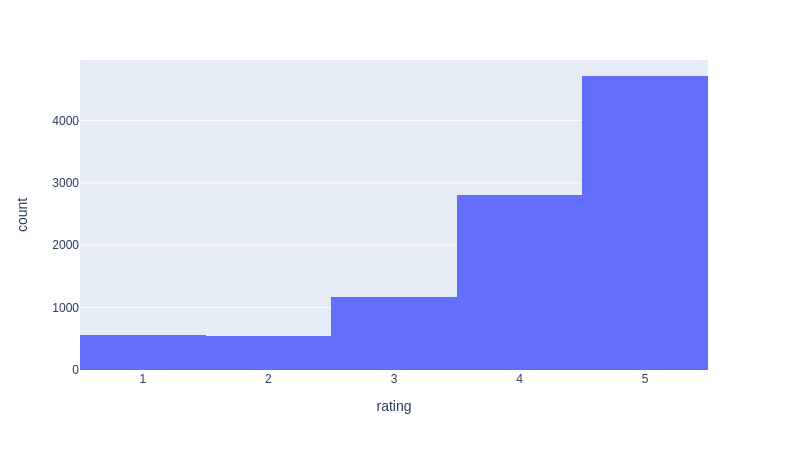

In [61]:
import plotly.express as px

# Interactive histogram.
fig = px.histogram(
    df,
    x="rating",
)

fig.show()

#### 3) Cleanse the data

For the title and text columns:
1. Remove long, unwanted strings (in this case, responses to reviews by hotel management)
2. Tokenize
3. Remove stopwords
4. Remove other irrelevant words
5. Stem words

In [62]:
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re


def remove_mgmt_response(reviews_text: str) -> str:
    """
    Remove management's response from review, return review.
    
    Keyword arguments:
    reviews_text -- text from all reviews as one long string
    """
    # remove substring: feedback from Sarah Junge and Jonathan
    reviews_text = re.sub(
        r'(Feedback from our guests|,Thank|, Thank|,We|, We|Dear)'  # starts w/
        + '(.*?)'  # include substring between beginning/end
        + '(Sarah Junge|Jonathan)',  # ends w/
        '', 
        reviews_text)
    
    reviews_text = re.sub(
        r'(It was a pleasure|Thank you for completing)'
        + '(.*?)'
        + '(Sarah Junge|Jonathan)',
        '', 
        reviews_text)
    
    # remove substring: feedback from unknown author(s)
    reviews_text = re.sub(
        r'Hello(.*?)(good nights sleep!|wherever you go!)', 
        '', 
        reviews_text)
    
    reviews_text = re.sub(
        r'Thank you for taking(.*?)(Cheers!|Seattle!)', 
        '', 
        reviews_text)
    
    reviews_text = re.sub(
        r'Thank you for sharing(.*?)(soon!)', 
        '', 
        reviews_text)
    
    return reviews_text


def cleanse_df_columns(
        df: pd.DataFrame, 
        cols: [str], 
        cleaner_function: object, 
        filter_list: [str] = []) -> pd.DataFrame:
    """Prepare df column(s) for vectorization and return as a new df.
    
    For each column: remove long, unwanted strings; tokenize; remove 
    stopwords; stem words; and remove stems of words found in stemmed 
    filter list, in that order.
    
    keyword arguments:
    df -- dataframe to tokenize
    cols -- name of column(s) to be tokenized
    cleaner_function -- function specialized for each particular 
    dataset that removes long, unwanted strings
    filter_list -- words whose stems will be removed from column(s)
    """
    tokenized_df = df.copy()
    tokenizer = RegexpTokenizer(r'\w+')  # removes punctuation
    stop_words = set(stopwords.words('english'))
    ps = PorterStemmer()
    
    # get stems of words in filter list
    filter_list_stems = [ps.stem(word) for word in filter_list]
    
    for col in cols:
        
        # remove long strings
        tokenized_df[col] = tokenized_df[col].apply(
            lambda row: cleaner_function(str(row)))
        # tokenize
        tokenized_df[col] = tokenized_df.apply(
            lambda row: tokenizer.tokenize(row[col].lower()), axis=1)
        # remove stopwords
        tokenized_df[col] = tokenized_df[col].apply(
            lambda tokens: [word for word in tokens if word not in stop_words])
        # stem words
        tokenized_df[col] = tokenized_df[col].apply(
            lambda tokens: [ps.stem(word) for word in tokens])
        # remove filter list word stems
        tokenized_df[col] = tokenized_df[col].apply(
            lambda stems: [
                stem for stem in stems if stem not in filter_list_stems])
        
    return tokenized_df


filter_list = ['hotel', 'hyatt', 'house', 'room', 'night', 'stay', 
               'day', 'get', 'back', 'ask', 'time', 'would', 'one', 
               'left', 'next', 'said', 'told', 'could', 'go', 'take',
               '1', '2', '4', '5', '6']

In [63]:
df_tokenized = cleanse_df_columns(
    df, ['text', 'title'], remove_mgmt_response, filter_list)

In [64]:
df_tokenized.head(3)

,hotel_id,rating,text,title
0,AWE2FvX5RxPSIh2RscTK,3,"[nice, quiet, know, train, track, near, train,...","[best, western, plu]"
1,AVwcj_OhkufWRAb5wi9T,4,"[king, suit, separ, bedroom, live, space, sofa...","[clean, solid, rate, heart, carmel]"
2,AVwcj_OhkufWRAb5wi9T,3,"[park, horribl, somebodi, ran, rental, car, tr...",[busi]


#### 4) Vectorize the data

Create word vector and vectorize data to make it useable in a logistic regression model.

In [65]:
from sklearn.feature_extraction.text import CountVectorizer


def vectorize_cols(df: pd.DataFrame, cols: [str]) -> pd.DataFrame:
    """Vectorize columns and return as a new dataframe.
    
    keyword arguments:
    df -- dataframe to vectorize
    cols -- name of column(s) to be vectorized
    """
    vectorized_df = df.copy()
    cv = CountVectorizer(binary=True)
    flat_list = []

    # Each row in each col contains a tokenized list;
    # for example, two columns in the first row might look like this:
    #     df[cols[0]][0] = ['nice', 'quiet', 'know']
    #     df[cols[1]][0] = ['train', 'track', 'near']
    # We need the cols in each row to be combined into one string, like this:
    #     'nice quiet know train track near'
    # So that finally strings from each row can be appended to one list, that 
    # looks like this:
    #     ['nice quiet know train track near', 'pass best western chang']
    # Then the rows (or 'documents') can be vectorized.
    for index, row in vectorized_df.iterrows(): 
        row_string = ''
        
        for col in cols:
            if not row_string:  # if first col to be added to row_string
                join_string = ''
            else:
                join_string = ' '
            row_string = join_string.join([row_string, ' '.join(row[col])])
        
        flat_list.append(row_string)

    X = cv.fit_transform(flat_list)
#     print(cv.vocabulary_)  # dict of unique vocabulary words
#     print(X.shape)
    return X

In [66]:
X = vectorize_cols(df_tokenized, ['text', 'title'])

#### 5a) Create logistic regression model to predict review rating (Model 1)

Split ratings data into training and testing subsets.

In [67]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, df_tokenized['rating'], train_size = 0.70)

Train model.

In [68]:
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore")

rating_model = LogisticRegression().fit(X_train, y_train)

Predict ratings.

In [69]:
y_predicted = rating_model.predict(X_test)

#### 5b) Validate Model 1

Display confusion matrix.

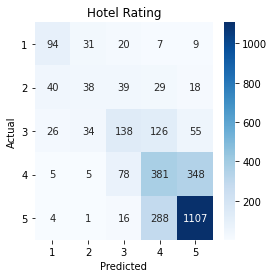

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from pandas import DataFrame


def display_hotel_rating_pred_confusion_matrix(
    y_test: pd.core.series.Series, y_predicted: pd.core.series.Series) -> None:
    """Display confusion matrix for predictions."""
    
    cm = metrics.confusion_matrix(y_test.values, y_predicted)
    
    # Show confusion matrix with colored background.
    labels = [str(num) for num in range(1, 6)]
    index = labels
    cols = labels
    df = DataFrame(cm, index=index, columns=cols)
    plt.figure(figsize = (4,4))
    ax = sns.heatmap(df, cmap='Blues', annot=True, fmt='g')
    bottom, top = ax.get_ylim()
    ax.set(title = 'Hotel Rating')
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_ylim(bottom, top)
    ax.set_xticklabels(
        ax.get_xticklabels(), rotation=0, horizontalalignment='center')
    ax.set_yticklabels(
        ax.get_yticklabels(), rotation=0, horizontalalignment='right')
    

display_hotel_rating_pred_confusion_matrix(y_test, y_predicted)

Get model accuracy.

In [71]:
accuracy_score = rating_model.score(X_test, y_test)
print('{:.2f}% Accuracy'.format(accuracy_score * 100))

59.86% Accuracy


Get precision and recall scores.

In [72]:
from sklearn.metrics import classification_report

classification_report = classification_report(y_test, y_predicted)
print(classification_report)

              precision    recall  f1-score   support

           1       0.56      0.58      0.57       161
           2       0.35      0.23      0.28       164
           3       0.47      0.36      0.41       379
           4       0.46      0.47      0.46       817
           5       0.72      0.78      0.75      1416

    accuracy                           0.60      2937
   macro avg       0.51      0.49      0.49      2937
weighted avg       0.59      0.60      0.59      2937



#### 6a) Create logistic regression model to predict review sentiment (Model 2)

Add classification column to dataframes and set value to 0, 1, or 2 (for bad, neutral, and good, respectively).

In [73]:
bad = [1, 2]
neutral = [3]
good = [4, 5]

df_classified = df_tokenized.copy()

sentiment_list = []
for index, row in df_classified.iterrows(): 
    if row['rating'] in bad:
        sentiment_list.append(1)
    elif row['rating'] in neutral:
        sentiment_list.append(2)
    elif row['rating'] in good:
        sentiment_list.append(3)
df_classified['sentiment'] = sentiment_list

df_classified.head()

,hotel_id,rating,text,title,sentiment
0,AWE2FvX5RxPSIh2RscTK,3,"[nice, quiet, know, train, track, near, train,...","[best, western, plu]",2
1,AVwcj_OhkufWRAb5wi9T,4,"[king, suit, separ, bedroom, live, space, sofa...","[clean, solid, rate, heart, carmel]",3
2,AVwcj_OhkufWRAb5wi9T,3,"[park, horribl, somebodi, ran, rental, car, tr...",[busi],2
3,AVwcj_OhkufWRAb5wi9T,5,"[cheap, excel, locat, price, somewhat, standar...",[good],3
4,AVwcj_OhkufWRAb5wi9T,2,"[advertis, websit, paid, may, lucki, mani, giv...","[low, chanc, come]",1


Split sentiment data into training and testing subsets.

In [74]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, df_classified['sentiment'], train_size = 0.70)

Train model.

In [75]:
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore")

sentiment_model = LogisticRegression().fit(X_train, y_train)

Predict review sentiment.

In [76]:
y_predicted = sentiment_model.predict(X_test)

#### 6b) Validate Model 2

Display confusion matrix.

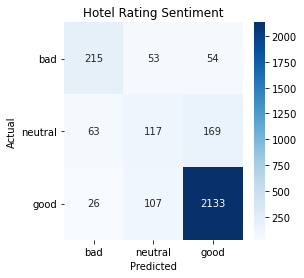

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from pandas import DataFrame


def display_hotel_sentiment_pred_confusion_matrix(
    y_test: pd.core.series.Series, y_predicted: pd.core.series.Series) -> None:
    """Display confusion matrix for predictions."""
    
    cm = metrics.confusion_matrix(y_test.values, y_predicted)
    
    # Show confusion matrix with colored background.
    labels = ['bad', 'neutral', 'good']
    index = labels
    cols = labels
    df = DataFrame(cm, index=index, columns=cols)
    plt.figure(figsize = (4,4))
    ax = sns.heatmap(df, cmap='Blues', annot=True, fmt='g')
    bottom, top = ax.get_ylim()
    ax.set(title = 'Hotel Rating Sentiment')
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_ylim(bottom, top)
    ax.set_xticklabels(
        ax.get_xticklabels(), rotation=0, horizontalalignment='center')
    ax.set_yticklabels(
        ax.get_yticklabels(), rotation=0, horizontalalignment='right')
    

display_hotel_sentiment_pred_confusion_matrix(y_test, y_predicted)

Get model accuracy.

In [78]:
accuracy_score = sentiment_model.score(X_test, y_test)
print('{:.2f}% Accuracy'.format(accuracy_score * 100))

83.93% Accuracy


Get precision and recall scores.

In [79]:
from sklearn.metrics import classification_report

classification_report = classification_report(y_test, y_predicted)
print(classification_report)

              precision    recall  f1-score   support

           1       0.71      0.67      0.69       322
           2       0.42      0.34      0.37       349
           3       0.91      0.94      0.92      2266

    accuracy                           0.84      2937
   macro avg       0.68      0.65      0.66      2937
weighted avg       0.83      0.84      0.83      2937



In [80]:
import math

rmse2 = math.sqrt(metrics.mean_squared_error(
    y_test, y_predicted))
print("RMSE: {:.4f}".format(rmse2))

RMSE: 0.4924
